[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202320_IMAGENES_Y_VISION/blob/main/Laboratorio%202/Practica/MISIS4825-M%26V2023%20-%20LAB2%20-%20Práctica.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

Práctica No. 2
==============

*Clasificación de imágenes satelitales con SVM y métodos ensembles*
--------------------------------------------------------------------

Objetivos
---------

-   Familiarizarse con el algoritmo de SVM.
-   Resolver un problema de clasificación de imágenes satelitales y evaluar métricas de desempeño.
-   Familiarizarse con técnicas de Ensemble y entender cómo su aplicación puede ayudar a mejorar las métricas de desempeño en la clasificación de imágenes satelitales.

Problema
--------

-   En esta ocasión, trabajaremos con el dataset "Satellite Image Classification". Este dataset cuenta con imágenes satelitales categorizadas en diferentes clases como desierto, área verde, agua y nublado. El tamaño de las imágenes es de 256x256 siendo estas RGB. El propósito es desarrollar un clasificador mediante el algoritmo SVM que pueda identificar correctamente cada uno de estos tipos de terrenos o fenómenos naturales.

Datos: [Satellite Image Classification](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

Para este ejercicio, utilizaremos las siguientes librerías.

In [1]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial

#### 1. Carga y exploración de los datos

In [2]:
def load_image(folder, width, height):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [3]:
X, y = load_image('data', 100, 100)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Tamaño de los datos
X.shape

(5631, 100, 100, 3)

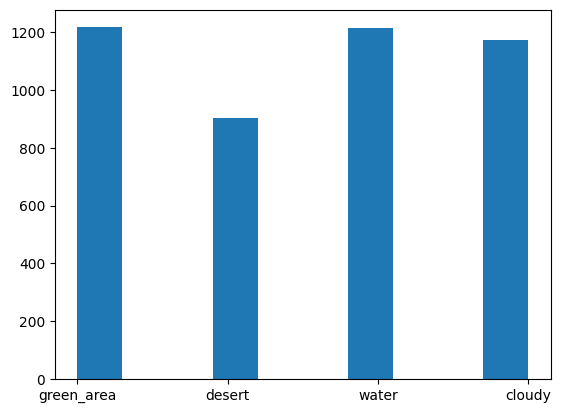

In [5]:
# Observar distribucón de clases
plt.hist(y_train)
plt.show()

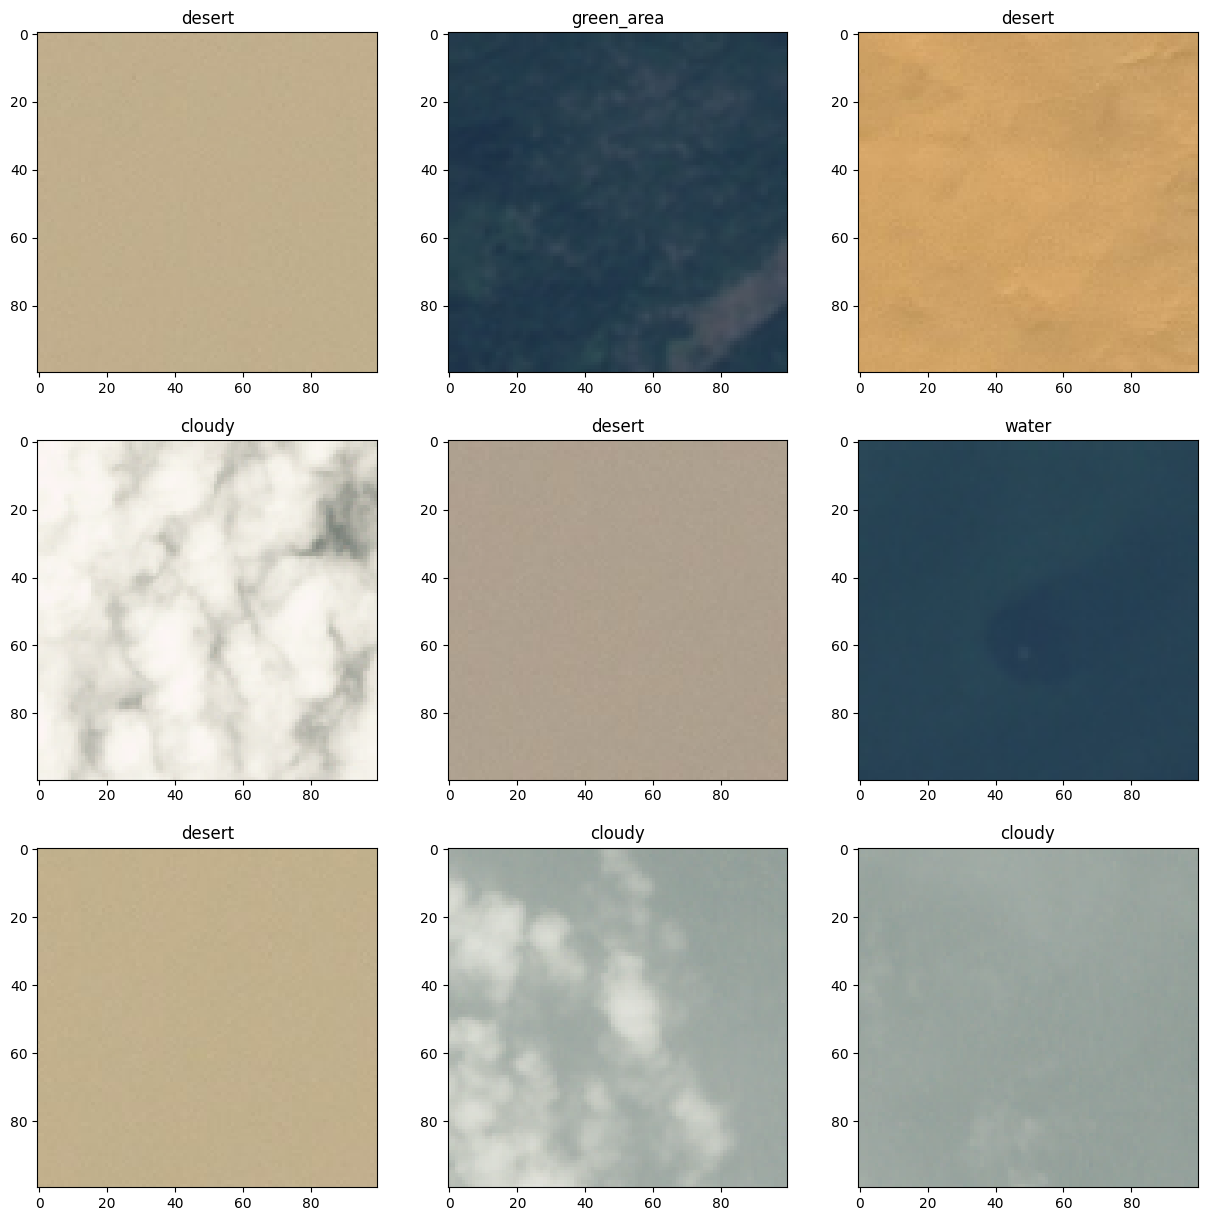

In [6]:
# Observar las imágenes
plt.figure(figsize=(15,15))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])

In [7]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Distribución de los labels de entrenamiento: ", dict(zip(unique_train, counts_train)))
print("Distribución de los labels de test: ", dict(zip(unique_test, counts_test)))

Distribución de los labels de entrenamiento:  {'cloudy': 1172, 'desert': 904, 'green_area': 1216, 'water': 1212}
Distribución de los labels de test:  {'cloudy': 328, 'desert': 227, 'green_area': 284, 'water': 288}


#### 2. Preparación de los Datos

##### 2.1 Estandarizacion

Sabiendo que estamos trabajando con imágenes RGB podríamos hacer estandarización diviendo por 255 (el máximo valor que puede tomar un píxel en una imagen de 8 bits).

Sin embargo, en este caso haremos una aproximación con StandardScaler pues centra los datos en 0 y asegura varianza unitaria. Lo que en algoritmos sensibles a escala como SVM puede ser muy útil.

In [8]:
# Convertir imágenes a vectores 1D
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Estandarizar las imágenes
scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)

##### 2.1 PCA (Principal Component Analysis)

Como vimos en la laboratorio anterior PCA puede ayudarnos a reducir el tiempo de entrenamiento y también puede mejorar el rendimiento del modelo al eliminar características redundantes o poco informativas

In [9]:
# Dimensionalidad de los datos sin PCA
x_train_standard.shape

(4504, 30000)

In [10]:
pca = PCA(0.95).fit(x_train_standard) # Conservar el 95% de la varianza

x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

In [11]:
# Numero de componentes principales
print(f"El número de componente principales que conservan el 95% de la varianza es: {pca.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca.shape

El número de componente principales que conservan el 95% de la varianza es: 2


(4504, 2)

#### 3. Modelamiento

En esta sección, emplearemos el algoritmo Support Vector Machine (SVM) para nuestro problema de clasificación de imágenes. SVM es un algoritmo de aprendizaje supervisado que busca encontrar un hiperplano en un espacio N-dimensional (N es el número de características) que clasifique de manera óptima los inputs en categorías.


##### Support Vector Machine

<img src="https://www.researchgate.net/publication/343397484/figure/fig1/AS:920431192182789@1596459305324/An-illustration-of-support-vector-machine-SVM-intuition.jpg" width="800">

##### Consideración

Al igual que KNN, SVM no puede procesar imágenes directamente. Para utilizar imágenes en SVM, es necesario transformarlas en vectores de características. Esta transformación se realiza al convertir las imágenes en arreglos unidimensionales.

In [12]:
# Entrenamiento y creación del modelo
start = time.time()

# Vamos a entrenarlos con varios Parámetros de C
# (Queremos un equilibrio entre la capacidad de generalización y la precisión en el conjunto de entrenamiento)
C = [0.1, 1, 10]

# Grid search
grid_search = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid={'C': C}, cv=5)

# Entrenamiento
grid_search.fit(x_train_pca, y_train)

# Tiempo de entrenamiento
end = time.time()

print(f"Tiempo de entrenamiento: {end - start}")

# Mejor modelo
best_model = grid_search.best_estimator_

Tiempo de entrenamiento: 298.9890739917755


In [13]:
# Mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'C': 10}


In [14]:
# Predicciones
y_pred = best_model.predict(x_test_pca)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8110026619343389
              precision    recall  f1-score   support

      cloudy       0.91      0.86      0.88       328
      desert       0.84      0.93      0.88       227
  green_area       0.78      0.69      0.73       284
       water       0.72      0.78      0.75       288

    accuracy                           0.81      1127
   macro avg       0.81      0.81      0.81      1127
weighted avg       0.81      0.81      0.81      1127



Matriz de confusión datos de entrenamiento
Precisión: 0.8228241563055062


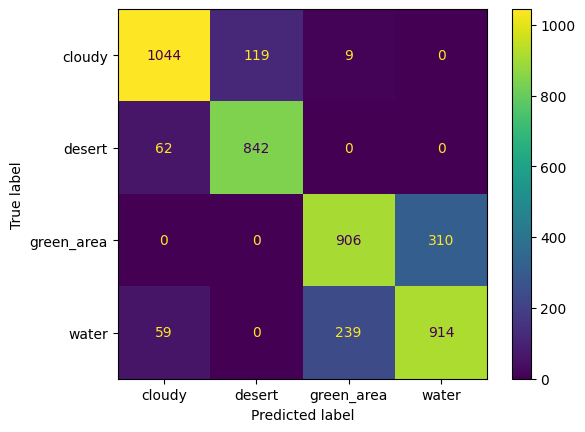

In [15]:
# Observemos la matriz se confusión
print("Matriz de confusión datos de entrenamiento")

print("Precisión:", accuracy_score(y_train, best_model.predict(x_train_pca)))

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, best_model.predict(x_train_pca))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

Matriz de confusión datos de test
Precisión: 0.8110026619343389


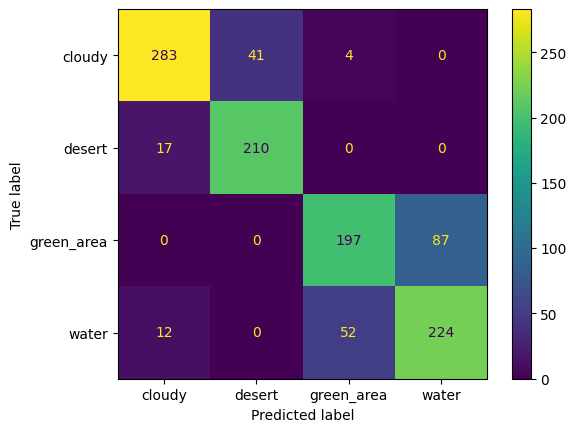

In [16]:
# Matriz de confusión para test
print("Matriz de confusión datos de test")

print("Precisión:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

Observemos ejemplos mal clasificados

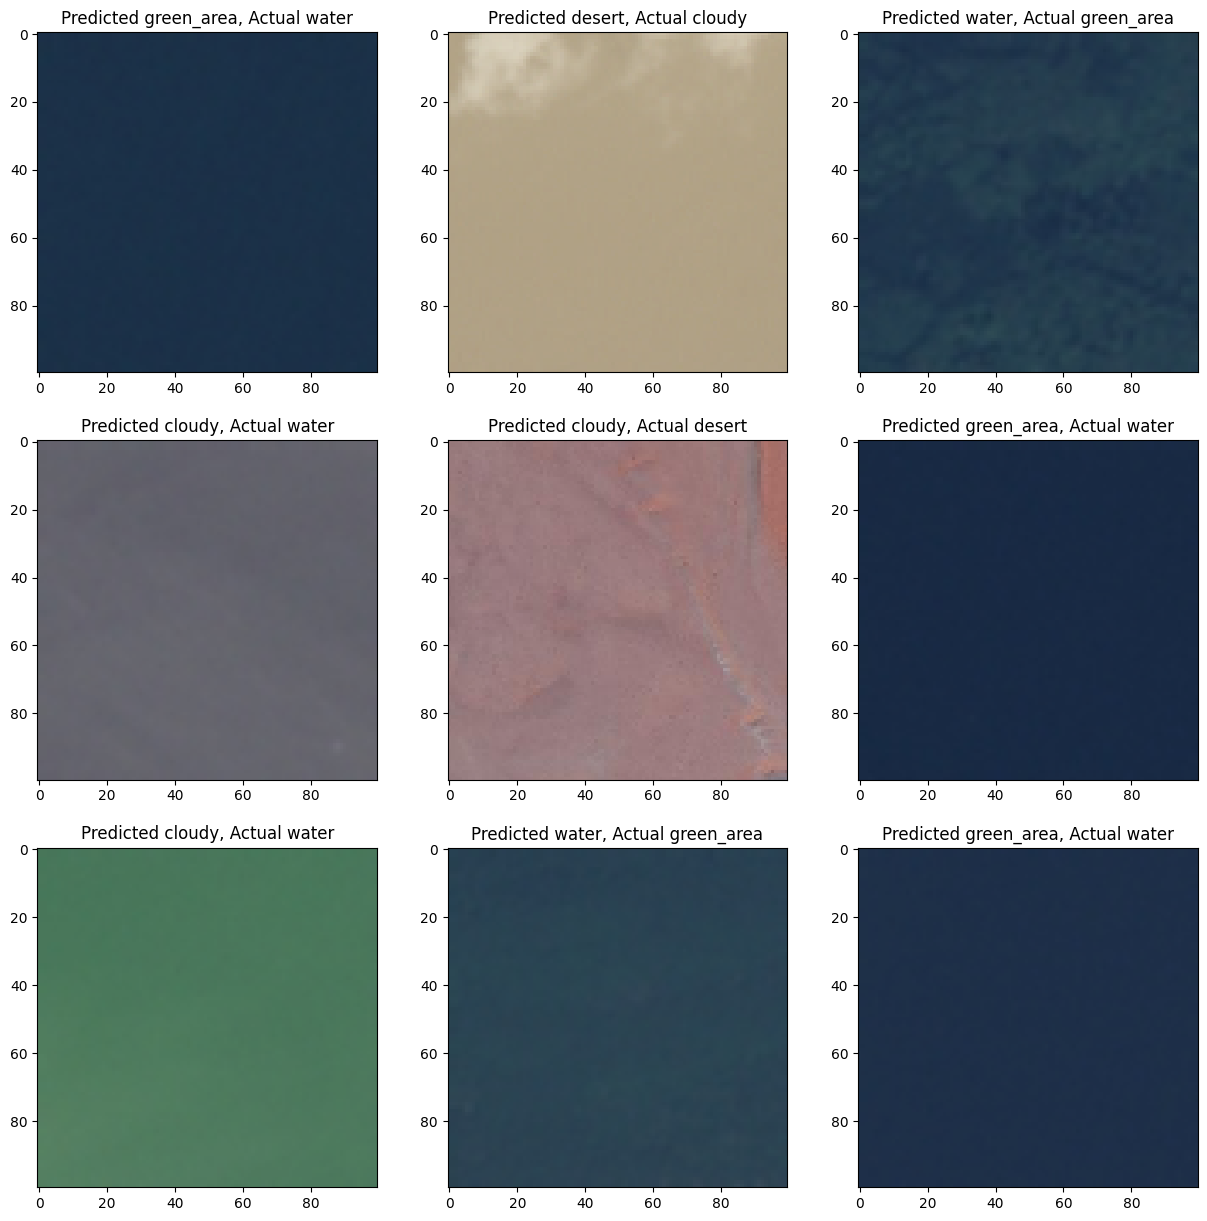

In [17]:
# Gráfico de ejemplos mal clasificados
incorrect_indices = np.nonzero(y_pred != y_test)[0]

rdn_numbers = np.random.choice(incorrect_indices, size=min(len(incorrect_indices), 9), replace=False)

plt.figure(figsize=(15,15))
for i in range(0, min(len(incorrect_indices), 9)):
    incorrect = rdn_numbers[i]
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect], cmap='gray')
    plt.title(f"Predicted {y_pred[incorrect]}, Actual {y_test[incorrect]}")
plt.show()

- ¿A qué se debe que el modelo no clasifique correctamente estas imágenes?
- ¿Influye el valor del color de los píxeles en la clasificación?
- ¿PCA con una explicación mayor de la variancia puede ayudar a mejorar el desempeño del modelo?
- ¿Qué pasaría si se utiliza un kernel no lineal, como RBF? ¿Cómo se ajustarían los hiperparámetros?

#### 4. Metodos Ensembles

Los métodos de conjunto (Ensemble) son técnicas que combinan las predicciones de múltiples modelos con el objetivo de mejorar la robustez y precisión sobre un único modelo. Existen varios métodos Ensemble populares. En particular nos centraremos en Gradient Boosting y como podría ayudarnos a mejorar el desempeño de nuestro modelo.

##### 4.1 Gradient Boosting
Gradient Boosting es un algoritmo de optimización que se utiliza para minimizar el error al añadir modelos de manera secuencial. A diferencia de otros métodos de conjunto que entrenan modelos independientemente, Gradient Boosting entrena modelos en función del error de los modelos anteriores.

Cómo funciona:

1.  Se inicia con un modelo base.
2.  Se calcula el residuo o error entre las predicciones del modelo y los valores reales.
3.  Se entrena un nuevo modelo para predecir estos residuos o errores.
4.  Se añade este nuevo modelo al conjunto.
5.  Se repiten los pasos 2 a 4 hasta alcanzar un número determinado de modelos o hasta que el error ya no disminuya significativamente.

<img src="https://1394217531-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvBP1svpACTB1R1x_U4%2F-Lw6zezdliKWkGknCJ6R%2F-Lw70EB_T-Y3OCO-L_4o%2Fimage.png?alt=media&token=a3edaf4a-d3d2-4c84-9a10-3d870c21d641">


Ventajas:

-   Es especialmente útil para datasets con muchas características como es el caso de las imágenes satelitales.
-   Proporciona una importante reducción del overfitting en comparación con otros métodos.

##### 4.2 Aplicación en nuestro problema

Con un ajuste adecuado de hiperparámetros y una cuidadosa validación, podemos esperar que Gradient Boosting potencie significativamente la precisión de nuestro clasificador. En particular, utilizando Scikit-Learn podemos definir y entrenar un modelo de Gradient Boosting por medio de la clase GradientBoostingClassifier. Cabe resaltar que que Gradient Boosting puede trabajar con una mayor cantidad de características que otros modelos, por lo que podríamos considerar trabajar con una representación de PCA que conserve un porcentaje más alto de la varianza.

*El objetivo del siguiente taller es resolver el mismo problema de clasificación de imágenes satelitales pero esta vez utilizando  métodos ensembles.*